# Titanic -  Kaggle 

### Background
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Approach
This notebook has be developed to perform some EDA and practice recently learned ML techniques on the well known Kaggle dataset

### Contents

1. [Settings and Data Import](#setting)
2. [Data Exploration](#explore)
3. [Feature Manipulation](#feature)
4. [Imputation](#imputation)
5. [Encode Categorical Variables](#encode)
6. [Train Test Split](#split)
7. [Standardisation](#standard)
8. [Baseline Model](#baseline)
9. [Logistic Regression](#lr)
10. [Decision Tree](#dtc)
11. [Finish - experimening](#fin)


<a id='settings'></a>

### 1. Settings and Data Import
#### Import libraries and data 

In [123]:
#import all the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, auc, precision_recall_curve, confusion_matrix, roc_auc_score, roc_curve, classification_report


# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Set random Seed to ensure reproducability
RSEED = 101


In [124]:
# Heres the test set is the validation set for Kaggle which does not include the survived variable
# All EDA will be done on the train set which will then be split into a test and train set in order to evaluate models
# The final model and preprocessing of data will then be applied on this 'test' set for submission to kaggle
train =pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape
# df_all = pd.concat([train,test], sort=False)
# df_all[:891] - train
# df_all[891:] - test

(891, 12)

In [125]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<a id='explore'></a>

### 2. Data Exploration
#### 2.1 Simple stats and missings

In [127]:
print("There are {} rows and {} columns in the training dataset.".format(train.shape[0], train.shape[1]))
print("There are {} rows and {} columns in the test dataset.".format(test.shape[0], test.shape[1]))
print("In the training data set the survival rate is  {:.1f}%".format(100 * train['Survived'].mean()))  

There are 891 rows and 12 columns in the training dataset.
There are 418 rows and 11 columns in the test dataset.
In the training data set the survival rate is  38.4%


In [128]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [129]:
train.describe(include = ['O']).T

,count,unique,top,freq
Name,891,891,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,G6,4
Embarked,889,3,S,644


#### Missings
Here we will also check the missings in the test data set as if they differ they will ned to be consodered for imputation  
**Train** - 177 age, 687 cabin and 2 embarked  
**Test** - 86 age, 327 cabin, 1 fare  
Fare will need to be imputed in the test data set

In [130]:
#Train
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

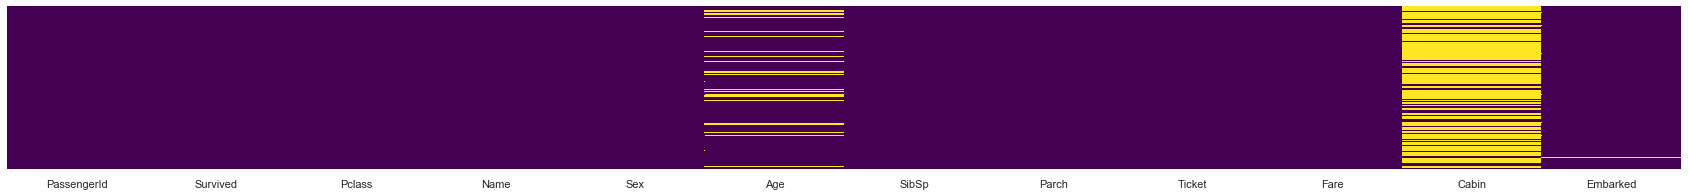

In [131]:
# Plot as heatmap
plt.figure(figsize =(30,3))
sns.heatmap(train.isnull(), cbar = False , 
        yticklabels = False , cmap = 'viridis')

In [132]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

####  2.2 Categorical Variables Survival Rates 
* Females have the highest survival rate - 74%
* SibSp 1 and 2 have a higher survival rate
* Class 1 have a higher survival rate
* Embarked C has a higher survival rate
* Parch 1 or 2 has a higher survival rate

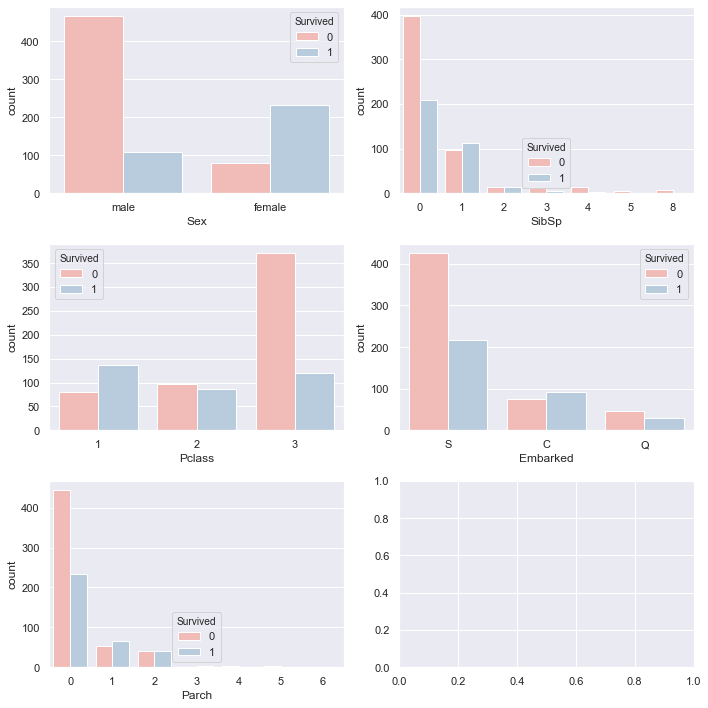

In [133]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
sns.countplot(x= 'Sex', hue ='Survived', data = train, palette='Pastel1', ax = ax[0,0])
sns.countplot(x= 'SibSp', hue ='Survived', data = train, palette='Pastel1', ax = ax[0,1])
sns.countplot(x= 'Pclass', hue ='Survived', data = train, palette='Pastel1', ax = ax[1,0])
sns.countplot(x= 'Embarked', hue ='Survived', data = train, palette='Pastel1', ax = ax[1,1])
sns.countplot(x= 'Parch', hue ='Survived', data = train, palette='Pastel1', ax = ax[2,0])

plt.tight_layout()
plt.show()

In [134]:
#Set to output all results for the next cell only 
InteractiveShell.ast_node_interactivity = "all"

###### Output the survival rate for each of the categorical variables

In [135]:
print("Survival Rate by Categorical Variables")

pd.DataFrame(round(100 * train.groupby('Sex')['Survived'].sum()/train.groupby('Sex')['Survived'].count(),2))
pd.DataFrame(round(100 * train.groupby('SibSp')['Survived'].sum()/train.groupby('SibSp')['Survived'].count(),2))
pd.DataFrame(round(100 * train.groupby('Pclass')['Survived'].sum()/train.groupby('Pclass')['Survived'].count(),2))
pd.DataFrame(round(100 * train.groupby('Embarked')['Survived'].sum()/train.groupby('Embarked')['Survived'].count(),2))
pd.DataFrame(round(100 * train.groupby('Parch')['Survived'].sum()/train.groupby('Parch')['Survived'].count(),2))

Survival Rate by Categorical Variables


,Survived
Sex,
female,74.20
male,18.89


,Survived
SibSp,
0,34.54
1,53.59
2,46.43
3,25.00
4,16.67
5,0.00
8,0.00


,Survived
Pclass,
1,62.96
2,47.28
3,24.24


,Survived
Embarked,
C,55.36
Q,38.96
S,33.70


,Survived
Parch,
0,34.37
1,55.08
2,50.00
3,60.00
4,0.00
5,20.00
6,0.00


In [136]:
#Reset last output only
InteractiveShell.ast_node_interactivity = "last_expr"

####  2.3 Continuous Variables Survival Rates 
###### Age  

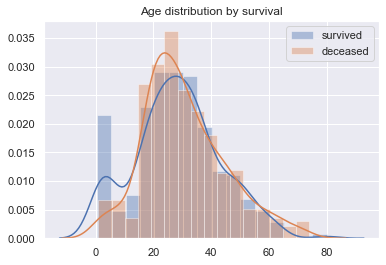

In [137]:
survived = train.loc[train['Survived'] == 1]
deceased = train.loc[train['Survived'] == 0]

sns.distplot(survived[['Age']].dropna(), label = 'survived')
sns.distplot(deceased[['Age']].dropna(), label = 'deceased')
plt.legend()
plt.title("Age distribution by survival")
plt.show()

###### Age vs. Sex
Split the age distribution by Sex  
Age seems to have a greater impact on male survival rate compared to female  
Males 0-4 have a high survival rate 65% compared to males 11-17 (16%) survival  
Females over 50 have high survial rate (91%)

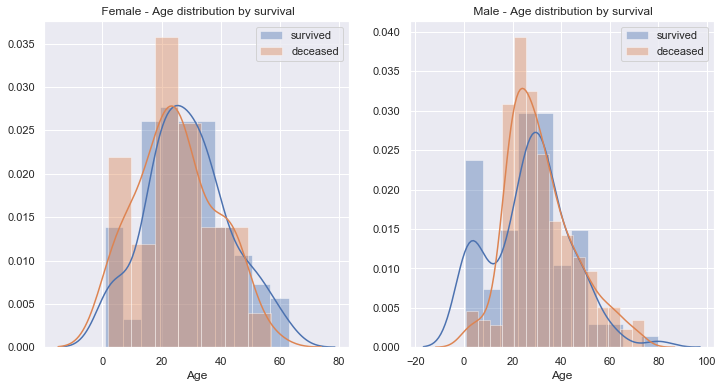

In [138]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

#Female
sns.distplot(survived.loc[survived['Sex']=='female', 'Age'].dropna(), label = 'survived',  ax = ax1)
sns.distplot(deceased.loc[deceased['Sex']=='female', 'Age'].dropna(), label = 'deceased', ax = ax1)
ax1.legend()
ax1.set_title(" Female - Age distribution by survival")

#Male
sns.distplot(survived.loc[survived['Sex']=='male', 'Age'].dropna(), label = 'survived',  ax = ax2)
sns.distplot(deceased.loc[deceased['Sex']=='male', 'Age'].dropna(), label = 'deceased', ax = ax2)
ax2.legend()
ax2.set_title(" Male - Age distribution by survival")

plt.show()

###### Check Survival Rates by different age groups

In [139]:
#Set to output all results for the next cell only 
InteractiveShell.ast_node_interactivity = "all"

In [140]:
print("Survival Rate 0-4")


train[train['Age']<5].groupby('Sex').agg(
                                            survival_rate = ('Survived', 'mean'),
                                            num_survived = ('Survived', 'sum'),
                                            total = ('Survived', 'count'))
print("Survival Rate 5-10")

train[(train['Age']>=5) & (train['Age']<11)].groupby('Sex').agg(
                                            survival_rate = ('Survived', 'mean'),
                                            num_survived = ('Survived', 'sum'),
                                            total = ('Survived', 'count'))



print("Survival Rate 11-17")

train[(train['Age']>=11) & (train['Age']<18)].groupby('Sex').agg(
                                            survival_rate = ('Survived', 'mean'),
                                            num_survived = ('Survived', 'sum'),
                                            total = ('Survived', 'count'))

print("Survival Rate 50+")

train[(train['Age']>=50)].groupby('Sex').agg(
                                            survival_rate = ('Survived', 'mean'),
                                            num_survived = ('Survived', 'sum'),
                                            total = ('Survived', 'count'))


Survival Rate 0-4


,survival_rate,num_survived,total
Sex,,,
female,0.705882,12,17
male,0.652174,15,23


Survival Rate 5-10


,survival_rate,num_survived,total
Sex,,,
female,0.5,7,14
male,0.4,4,10


Survival Rate 11-17


,survival_rate,num_survived,total
Sex,,,
female,0.791667,19,24
male,0.160000,4,25


Survival Rate 50+


,survival_rate,num_survived,total
Sex,,,
female,0.909091,20,22
male,0.134615,7,52


In [141]:
# Reset last output only
InteractiveShell.ast_node_interactivity = "last_expr"

###### Fare Distribution
Survived class has a wider distribution and higher average fare

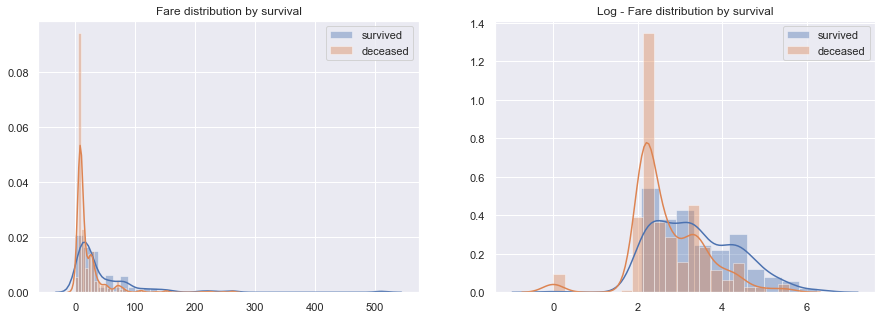

In [142]:
# Chek distribution of the fare variable

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

#Plot the Fare
sns.distplot(survived[['Fare']].dropna(), label = 'survived', ax = ax1)
sns.distplot(deceased[['Fare']].dropna(), label = 'deceased', ax = ax1)
ax1.legend()
ax1.set_title("Fare distribution by survival")


#Check log distribution of the fare
sns.distplot(np.log(survived[['Fare']].dropna() +1 ), label = 'survived', ax = ax2)
sns.distplot(np.log(deceased[['Fare']].dropna() +1 ), label = 'deceased', ax = ax2)
ax2.legend()
ax2.set_title("Log - Fare distribution by survival")
plt.show()


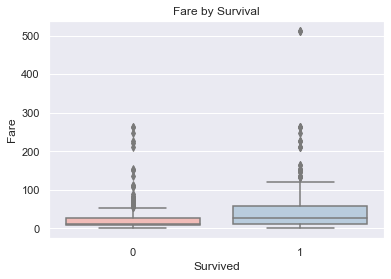

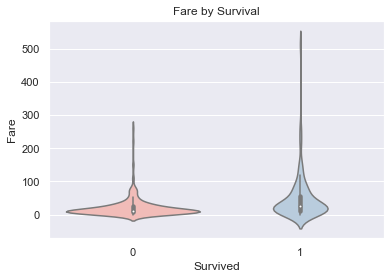

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


In [143]:
sns.boxplot(x= 'Survived', y='Fare',data = train, palette='Pastel1')
plt.title('Fare by Survival')
plt.show()
sns.violinplot(x= 'Survived', y='Fare',data = train, palette='Pastel1')
plt.title('Fare by Survival')
plt.show()

#Get the descriptor stats for Fare for the survived class
train.groupby('Survived').describe()['Fare']

###### Have a look at a few of the higher fares


Fare is the total fare and not the individual ticket price and as such will be incorporating family size as part of this variable. We will revisit fare again once we have looked at family size to see if indivisula fare makes more sense

In [144]:
train[train['Fare']>250]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


In [145]:
# Below is an example of a family of 6 same (ticket id and fare)
train[train['Ticket']=='19950']
test[test['Ticket']=='19950']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
53,945,1,"Fortune, Miss. Ethel Flora",female,28.0,3,2,19950,263.0,C23 C25 C27,S
69,961,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.0,C23 C25 C27,S


<a id='feature'></a>
### 3. Feature Engineering
Here we will look at some feature engineering
We should ensure everything on the train dataset is replicated on the test dataset

#### Cabin
Cabin B,D and E have the highest survival rate. Though most cabins are unnown it may be a useful feature so we will keep it for now

In [146]:
#Fill N/A with U for unknown and get the first character for the cabin 
# drop the original cabin variable and rename the new one back t cabin
train['Cabin1'] = train['Cabin'].fillna('U').str[0] 
train.drop('Cabin', axis =1, inplace = True)
train.rename(columns={'Cabin1':'Cabin'}, inplace=True)

# Apply the transformation to the test data set
test['Cabin1'] = test['Cabin'].fillna('U').str[0] 
test.drop('Cabin', axis =1, inplace = True)
test.rename(columns={'Cabin1':'Cabin'}, inplace=True)

In [147]:
pd.DataFrame(round(100 * train.groupby('Cabin')['Survived'].sum()/train.groupby('Cabin')['Survived'].count(),0))

,Survived
Cabin,
A,47.0
B,74.0
C,59.0
D,76.0
E,75.0
F,62.0
G,50.0
T,0.0
U,30.0


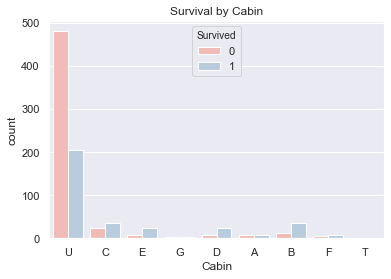

In [148]:
sns.countplot(x= 'Cabin', hue ='Survived', data = train, palette='Pastel1')
plt.title('Survival by Cabin')
plt.show()

#### Name
Miss, Mrs and Master have the highest survival rate consistent with what we have seen already with females and male children

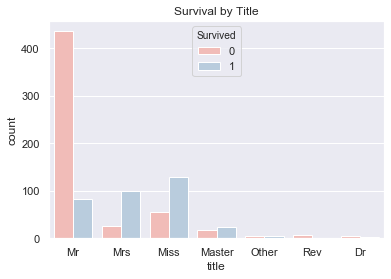

In [149]:
#Function to get the title from the name
def get_title(name):
    if name.find ("Mr.") >=0 or name.find ("Mr ") >=0:
        return "Mr"
    # group Mrs and Mme together
    elif name.find ("Mrs.") >=0  or  name.find ("Mme. ") >=0:
        return 'Mrs'
    # group Miss and Mlle together
    elif name.find ("Miss.") >=0  or name.find ("Mlle.") >=0:
        return 'Miss'
    elif name.find ("Master.") >=0 :
        return 'Master'
    elif name.find ("Dr.") >=0 :
        return 'Dr'
    elif name.find ("Rev.") >=0 :
        return 'Rev'
    else:
        return 'Other'

# Apply the function to get the title
train['title'] = train['Name'].apply(get_title) 

#check the others
#Only a handful of colonel lasy etc. Due to low numbers we will leave as other
# train[train['title'] =='Other']

#Have a look at survival rate by title
pd.DataFrame(round(100 * train.groupby('title')['Survived'].sum()/train.groupby('title')['Survived'].count(),0))
sns.countplot(x= 'title', hue ='Survived', data = train, palette='Pastel1')
plt.title('Survival by Title')
plt.show()

# Apply the transformation to the test data set
test['title'] = test['Name'].apply(get_title)

#### Family Size
There are two fields that contribute to family size 
* SibSp - Sibling Spouse 
* Parch - Parent Child
Create a new field that is a combination of the two
Family size 2-4 has the highest survival rate

In [150]:
#Family size = sibsp + Parch + 1 (self)
train['family_size'] = train['SibSp'] + train['Parch'] + 1
test['family_size'] = test['SibSp'] + test['Parch'] + 1

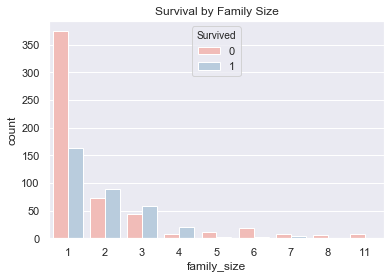

In [151]:
pd.DataFrame(round(100 * train.groupby('family_size')['Survived'].sum()/train.groupby('family_size')['Survived'].count(),0))
sns.countplot(x= 'family_size', hue ='Survived', data = train, palette='Pastel1')
plt.title('Survival by Family Size')
plt.show()

#### Further engineer family size
Create column family_size_grouped with the following values:
May want to change this to categorical

* 0 - Family size = 0   (alone)
* 1 - Family size = 2-4 (small family)
* 2 - Family size = 4+  (large family)


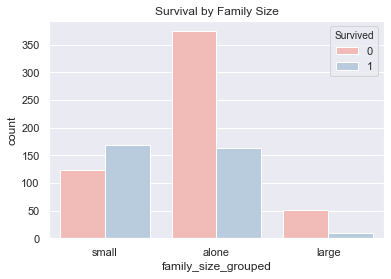

In [152]:
# train['family_size_grouped'] = train['family_size'].apply(lambda x: 0 if x == 1 else (1 if x < 5 else 2))
# test['family_size_grouped'] = test['family_size'].apply(lambda x: 0 if x == 1 else (1 if x < 5 else 2))
train['family_size_grouped'] = train['family_size'].apply(lambda x: 'alone' if x == 1 else ('small' if x < 5 else 'large'))
test['family_size_grouped'] = test['family_size'].apply(lambda x: 'alone' if x == 1 else ('small' if x < 5 else 'large'))

pd.DataFrame(round(100 * train.groupby('family_size_grouped')['Survived'].sum()/train.groupby('family_size_grouped')['Survived'].count(),0))
sns.countplot(x= 'family_size_grouped', hue ='Survived', data = train, palette='Pastel1')
plt.title('Survival by Family Size')
plt.show()

#### Fare Revisited
Lets have another look ad fare but this time divide by family size to get individual fare

In [153]:
train['single_fare'] = train['Fare']/train['family_size']
test['single_fare'] = test['Fare']/test['family_size']

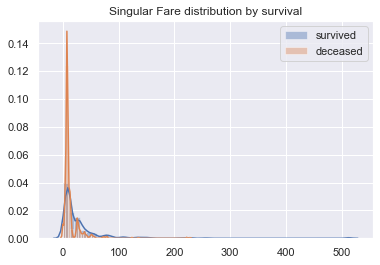

In [154]:
survived = train.loc[train['Survived'] == 1]
deceased = train.loc[train['Survived'] == 0]

# sns.distplot(survived[['single_fare']].dropna(), label = 'survived')
# sns.distplot(deceased[['single_fare']].dropna(), label = 'deceased')

sns.distplot(survived[['single_fare']].dropna(), label = 'survived')
sns.distplot(deceased[['single_fare']].dropna(), label = 'deceased')
plt.legend()
plt.title("Singular Fare distribution by survival")
plt.show()

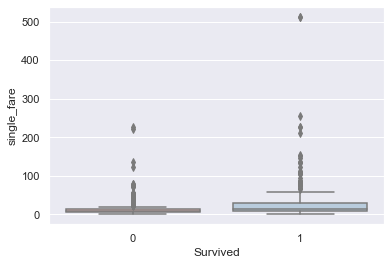

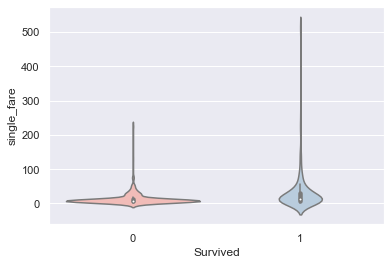

In [155]:
sns.boxplot(x= 'Survived', y='single_fare',data = train, palette='Pastel1')
plt.show()
sns.violinplot(x= 'Survived', y='single_fare',data = train, palette='Pastel1')
plt.show()

In [156]:
train.groupby('Survived').describe()['single_fare']

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,13.651162,18.918880,0.0,7.2264,7.925,13.0,227.5250
1,342.0,29.973691,51.116704,0.0,7.7500,13.000,30.5,512.3292


###### Log Transform Fare
Do a log trainsform of the fare columns  - 
tried using this but don't think it makes a difference so will just use single fare
Comment this out

In [157]:
# train['log_fare'] = np.log(train['Fare']+1)
# train['log_single_fare'] = np.log(train['single_fare']+1)

### Correlation

Text(0.5, 1, 'Correlation Matrix')

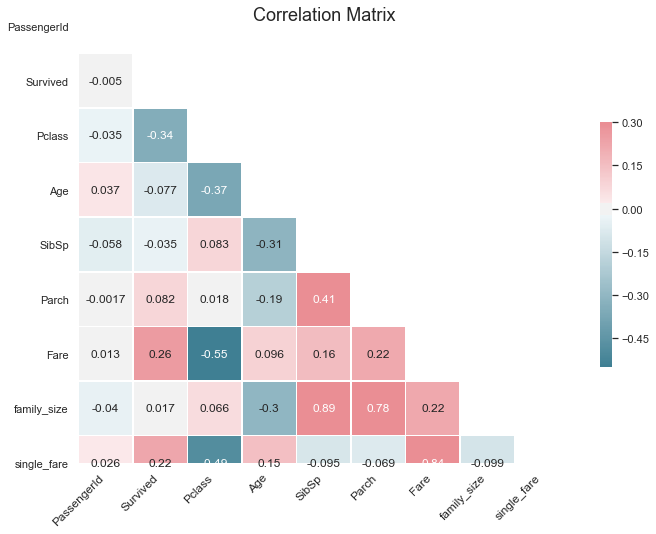

In [158]:
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
sns.set(style="white")
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium')
ax.set_title('Correlation Matrix', fontsize =18)

<a id='imputation'></a>
### 4. Imputation
Here we will look at some feature engineering
We should ensure everything on the train dataset is replicated on the test dataset

So we have some missings to deal with

* **Cabin** - This has already been filled with U
* **Age** - There are a high % missing so we should be careful about the imputation method. We will revisit this at the end
* **Embarked** - Only 2 missing so will impute with the mode of the train
* **Fare** - Only one missing in the test set so impute with the mdeian of the train 
Train - 177 age missing, 687 cabin and 2 embarked



###### Embarked

In [159]:
# Check distribution on the train dataset
train.isna().sum()
train['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [160]:
#Get the mode of Embarked (This only needs filling in the train data set as test doesn't have any missing)
impute_mode = SimpleImputer(strategy='most_frequent')
#Fit on the train dataset
impute_mode.fit(train[['Embarked']])
#Fill the missings with mode
train['Embarked'] = impute_mode.transform(train[['Embarked']])
#Check 
train['Embarked'].value_counts(dropna=False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

###### Fare

In [161]:
#row with missing fare
test[test['Fare'].isna()]
# test.iloc[152]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin,title,family_size,family_size_grouped,single_fare
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,U,Mr,1,alone,NaN


In [162]:
#Fare needs imputing in the test set
imp_med = SimpleImputer(strategy='median')
#Fit on train
imp_med.fit(train[['Fare']])
#Impute on the test set
test[['Fare']] = imp_med.transform(test[['Fare']])
#Also need to update the single fare feature
test['single_fare'] = test['Fare']/test['family_size']
# # Check the results
test.iloc[152]

PassengerId                          1044
Pclass                                  3
Name                   Storey, Mr. Thomas
Sex                                  male
Age                                  60.5
SibSp                                   0
Parch                                   0
Ticket                               3701
Fare                              14.4542
Embarked                                S
Cabin                                   U
title                                  Mr
family_size                             1
family_size_grouped                 alone
single_fare                       14.4542
Name: 152, dtype: object

###### Age still needs to be imputed but will come back to it after we have completed encoding of cat vars

<a id='encode'></a>
### 5. Encode the Categorical Variables

In [163]:
#First lets get rid of unecesarry columns ( dropping fare as we are keeping single_fare)
train.drop(['PassengerId','Name','Ticket', 'Fare'], inplace =True,axis = 1)
test.drop(['Name','Ticket','Fare'], inplace =True,axis = 1) # keep passenger id in test for final submission

In [164]:
#Set the coluns to be encoded
dummy_cols = ['Sex','Embarked','Cabin','title','family_size_grouped']
train = pd.get_dummies(train, columns = dummy_cols, drop_first=True)
test = pd.get_dummies(test, columns = dummy_cols, drop_first=True)

#### MICE Imputation of age column
This uses the other columns to try to predict the age column

In [165]:
from impyute.imputation.cs import mice

#mice imputation on train dataset
mice_imputed = mice(train.drop('Survived', axis=1).values)
# create new imputed age column - Age is the second column so index =1
train['imputed_age'] = mice_imputed[:, 1]
# Set min age to be 0 as impitation has calcultaed some -ve age values
train.loc[train['imputed_age']<0,'imputed_age'] = 0

# DO the same for the test dataset 
mice_imputed_test = mice(test.values)
test['imputed_age'] = mice_imputed_test[:, 1]
test.loc[train['imputed_age']<0,'imputed_age'] = 0

# drop the original age column and rename imputed age to age
train.drop('Age', axis =1, inplace = True)
train.rename(columns={'imputed_age':'Age'}, inplace=True)
test.drop('Age', axis =1, inplace = True)
test.rename(columns={'imputed_age':'Age'}, inplace=True) 

#### Create further categorical variables on age and encode them
###### Age group column

In [166]:
# Add a new Age grouped columns. 
train['Age_Group'] = pd.cut(train['Age'],bins=[0,4,10,17,25, 40,55,99],
                            include_lowest=True,
                            labels=['0-4','5-10','11-17','18-25','26-40','41-55','55+'])
# Do the same for test
test['Age_Group'] = pd.cut(test['Age'],bins=[0,4,10,17,25, 40,55,99],
                            include_lowest=True,
                            labels=['0-4','5-10','11-17','18-25','26-40','41-55','55+'])

In [167]:
# Check the survival rate for the new age group caregories
train.groupby('Age_Group').agg(
                                            survival_rate = ('Survived', 'mean'),
                                            num_survived = ('Survived', 'sum'),
                                            total = ('Survived', 'count'))

train.groupby(['Sex_male','Age_Group']).agg(
                                            survival_rate = ('Survived', 'mean'),
                                            num_survived = ('Survived', 'sum'),
                                            total = ('Survived', 'count'))

survival_rate  num_survived  total
Sex_male Age_Group                                    
0        0-4             0.600000            12     20
         5-10            0.533333             8     15
         11-17           0.666667            20     30
         18-25           0.736264            67     91
         26-40           0.800000            84    105
         41-55           0.772727            34     44
         55+             0.888889             8      9
1        0-4             0.653846            17     26
         5-10            0.363636             4     11
         11-17           0.142857             4     28
         18-25           0.111111            14    126
         26-40           0.179775            48    267
         41-55           0.204545            18     88
         55+             0.129032             4     31

###### Age group combined with sex column

In [168]:
#Combine age and sex in another column 
def age_sex(age_band, is_male):
    if is_male == 1:
        age_sex = 'M-' + str(age_band)
    else:
        age_sex = 'F-' + str(age_band)
    return age_sex

#Apply function for train and test
train['age_sex'] = train.apply(lambda x:age_sex(x['Age_Group'], x['Sex_male']), axis = 1)
test['age_sex'] = train.apply(lambda x:age_sex(x['Age_Group'], x['Sex_male']), axis = 1)

#### Convert the two new columns into dummies

In [169]:
dummy_cols = ['Age_Group', 'age_sex']
train = pd.get_dummies(train, columns = dummy_cols, drop_first=True)
test = pd.get_dummies(test, columns = dummy_cols, drop_first=True)

In [170]:
# Drop some surplus columns
# SibSp and Parch now replaced by family_ size
to_drop = ['SibSp', 'Parch', ]
train.drop(to_drop, axis = 1, inplace = True)
test.drop(to_drop, axis = 1, inplace = True)

<a id='split'></a>
### 6. Train Test Split
Here we will split the 'train' dataset into train an test portion to be able to evaluate the model.
Standardisation will be completed after this to prevent data leakage

In [171]:
X = train.drop(columns = 'Survived', axis =1).copy()
y = train['Survived'].copy()
X_train, X_test, y_train , y_test = train_test_split(X, y, stratify=y, test_size = 0.25, random_state =RSEED )

print('X_train has {} rows and X_test has {} rows'.format(X_train.shape[0],X_test.shape[0]))
X_train.columns
# This is annoying to get round set with copy warning
X_train = X_train.copy()
X_test = X_test.copy()

X_train has 668 rows and X_test has 223 rows


<a id='standard'></a>
### 7. Standardisation

In [172]:
# declare the columns to standardise
to_standard = ['Pclass','family_size','single_fare', 'Age']

#fit standard scaler
std_scale = StandardScaler()
std_scale.fit(X_train[to_standard])

# Transform train and test
X_train[to_standard] = std_scale.transform(X_train[to_standard])
X_test[to_standard] = std_scale.transform(X_test[to_standard])
# and the original test set
test[to_standard] = std_scale.transform(test[to_standard])

<a id='baseline'></a>
### 8. Baseline Model
Basic LR Model with just a few columns
I don't think accuracy is the best metric due to imbalanced class but its what kaggle is using so we will evaluate on this metric  
Train - 81.1%  
Test - 74.4%



In [173]:
#Check the columns
X_train.columns

Index(['Pclass', 'family_size', 'single_fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_U', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Other', 'title_Rev',
       'family_size_grouped_large', 'family_size_grouped_small', 'Age',
       'Age_Group_5-10', 'Age_Group_11-17', 'Age_Group_18-25',
       'Age_Group_26-40', 'Age_Group_41-55', 'Age_Group_55+',
       'age_sex_F-11-17', 'age_sex_F-18-25', 'age_sex_F-26-40',
       'age_sex_F-41-55', 'age_sex_F-5-10', 'age_sex_F-55+', 'age_sex_M-0-4',
       'age_sex_M-11-17', 'age_sex_M-18-25', 'age_sex_M-26-40',
       'age_sex_M-41-55', 'age_sex_M-5-10', 'age_sex_M-55+'],
      dtype='object')

C:\Users\rache\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on the train set: 0.811
Accuracy on the test set: 0.744

f1 on the train set: 0.749
f1 on the test set: 0.637

ROC AUC SCORE on the train set: 0.864
ROC AUC SCORE on the test set: 0.817

Baseline ROC AUC: 0.500

              precision    recall  f1-score   support

           0      0.763     0.847     0.803       137
           1      0.704     0.581     0.637        86

    accuracy                          0.744       223
   macro avg      0.734     0.714     0.720       223
weighted avg      0.740     0.744     0.739       223

[[116  21]
 [ 36  50]]


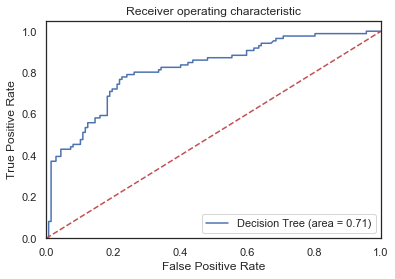

In [176]:
#Baseline model on 4 features
features = ['single_fare','Sex_male', 'Pclass', 'Age']
logreg = LogisticRegression(random_state =RSEED)
logreg.fit(X_train[features], y_train) 

train_probs = logreg.predict_proba(X_train[features])[:, 1]
test_probs = logreg.predict_proba(X_test[features])[:, 1]

train_pred = logreg.predict(X_train[features])
test_pred = logreg.predict(X_test[features])



def evaluate_model(test_pred, test_probs, train_pred, train_probs, train_label, test_label):

    print("Accuracy on the train set: {0:.3f}".format(accuracy_score(train_label, train_pred)))
    print("Accuracy on the test set: {0:.3f}\n".format(accuracy_score(test_label, test_pred)))

    print("f1 on the train set: {0:.3f}".format(f1_score(train_label,train_pred )))
    print("f1 on the test set: {0:.3f}\n".format(f1_score(test_label,test_pred )))

    print("ROC AUC SCORE on the train set: {0:.3f}".format(roc_auc_score(train_label,train_probs)))
    print("ROC AUC SCORE on the test set: {0:.3f}\n".format(roc_auc_score(test_label,test_probs  )))

    print("Baseline ROC AUC: {0:.3f}\n".format(roc_auc_score(test_label, [1 for _ in range(len(test_label))])))

    print(classification_report(test_label, test_pred, digits=3))

    print(confusion_matrix(test_label, test_pred, labels=None))

    # Plot the roc curve

    logit_roc_auc = roc_auc_score(test_label, test_pred)
    fpr, tpr, thresholds = roc_curve(test_label, test_probs)
    plt.figure()
    plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
evaluate_model(test_pred, test_probs, train_pred, train_probs, y_train, y_test)

<a id='lr'></a>
### 9. Grid Search CV Logistic Regression
Accuracy on the train set: 84.1%  
Accuracy on the test set: 82.1%  
f1 on the test set: 75.3%

In [178]:
from sklearn.model_selection import GridSearchCV

features = ['Pclass',  'single_fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_U', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Other', 'title_Rev',
       'Age','family_size_grouped_large', 'family_size_grouped_small'
    ]

#   'Age_Group_5-10', 'Age_Group_11-17', 'Age_Group_18-25',
#        'Age_Group_26-40', 'Age_Group_41-55', 'Age_Group_55+',
#        'age_sex_F-11-17', 'age_sex_F-18-25', 'age_sex_F-26-40',
#        'age_sex_F-41-55', 'age_sex_F-5-10', 'age_sex_F-55+', 'age_sex_M-0-4',
#        'age_sex_M-11-17', 'age_sex_M-18-25', 'age_sex_M-26-40',
#        'age_sex_M-41-55', 'age_sex_M-5-10', 'age_sex_M-55+'
#        'family_size'

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 1, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


#Pass the dicitionary and other parameters to GridSearchCV to create a GridSearchCV object
LR = LogisticRegression(solver='liblinear', random_state=RSEED)

gridCV = GridSearchCV(LR, hyperparameters, cv=5, return_train_score=True, scoring = ('accuracy'))
gridCV.fit(X_train[features], y_train) 

# # display the results
bestC = gridCV.best_params_['C']
bestP = gridCV.best_params_['penalty']
print ("The best parameters are: cost=", bestC , " and penalty=", bestP, "\n")
pd.DataFrame(gridCV.cv_results_)

The best parameters are: cost= 1.0  and penalty= l2 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006581,5.016253e-04,0.001191,4.029725e-04,1,l1,"{'C': 1.0, 'penalty': 'l1'}",0.792593,0.843284,0.879699,...,0.829341,0.029926,2,0.848030,0.837079,0.833645,0.856075,0.848598,0.844685,0.008197
1,0.003006,1.680836e-05,0.000995,1.451027e-06,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.807407,0.843284,0.879699,...,0.832335,0.026663,1,0.844278,0.838951,0.828037,0.856075,0.852336,0.843936,0.009956
2,0.012374,1.037737e-02,0.001594,7.996464e-04,2.15443,l1,"{'C': 2.154434690031884, 'penalty': 'l1'}",0.792593,0.843284,0.879699,...,0.826347,0.031469,4,0.844278,0.835206,0.837383,0.857944,0.848598,0.844682,0.008179
3,0.003192,3.987791e-04,0.000997,1.784161e-07,2.15443,l2,"{'C': 2.154434690031884, 'penalty': 'l2'}",0.792593,0.843284,0.879699,...,0.826347,0.031469,4,0.846154,0.837079,0.837383,0.859813,0.854206,0.846927,0.009030
4,0.006981,6.309018e-04,0.000997,4.422006e-07,4.64159,l1,"{'C': 4.641588833612778, 'penalty': 'l1'}",0.792593,0.843284,0.879699,...,0.826347,0.031469,4,0.844278,0.842697,0.839252,0.861682,0.854206,0.848423,0.008286
5,0.002992,3.234067e-07,0.000997,4.909339e-07,4.64159,l2,"{'C': 4.641588833612778, 'penalty': 'l2'}",0.792593,0.843284,0.879699,...,0.826347,0.031469,4,0.844278,0.838951,0.839252,0.857944,0.854206,0.846926,0.007796
6,0.018750,5.404181e-03,0.000998,5.135693e-07,10,l1,"{'C': 10.0, 'penalty': 'l1'}",0.800000,0.843284,0.879699,...,0.827844,0.029968,3,0.848030,0.844569,0.839252,0.863551,0.854206,0.849922,0.008369
7,0.002992,3.504023e-07,0.000998,5.091228e-07,10,l2,"{'C': 10.0, 'penalty': 'l2'}",0.792593,0.843284,0.879699,...,0.824850,0.032283,8,0.846154,0.844569,0.839252,0.857944,0.856075,0.848799,0.007108


Accuracy on the train set: 0.841
Accuracy on the test set: 0.821

f1 on the train set: 0.790
f1 on the test set: 0.753

ROC AUC SCORE on the train set: 0.890
ROC AUC SCORE on the test set: 0.850

Baseline ROC AUC: 0.500

              precision    recall  f1-score   support

           0      0.830     0.891     0.859       137
           1      0.803     0.709     0.753        86

    accuracy                          0.821       223
   macro avg      0.816     0.800     0.806       223
weighted avg      0.819     0.821     0.818       223

[[122  15]
 [ 25  61]]


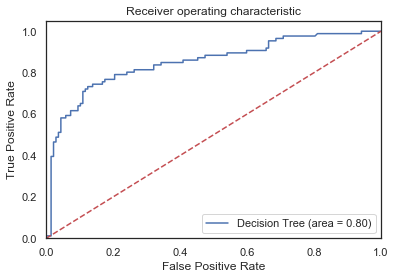

In [179]:
#Refit on all of the train data and validate agianst the test 
logreg = LogisticRegression(solver='liblinear',penalty = bestP, C = bestC, random_state =RSEED)

#fit the model with the best params
logreg.fit(X_train[features], y_train)

#Make the predictions
train_probs = logreg.predict_proba(X_train[features])[:, 1]
test_probs = logreg.predict_proba(X_test[features])[:, 1]
train_pred = logreg.predict(X_train[features])
test_pred = logreg.predict(X_test[features])

#evaluate the model
evaluate_model(test_pred, test_probs, train_pred, train_probs, y_train, y_test)

<a id='dtc'></a>
### 10. Grid Search CV DTC
Accuracy on the train set: 88.6%  
Accuracy on the test set: 81.2%  
f1 on the test set: 75.3%


In [196]:
from sklearn.tree import DecisionTreeClassifier

features = ['Pclass',  'single_fare',  'Embarked_Q',
       'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_U', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Other', 'title_Rev',
       'family_size_grouped_large', 'family_size_grouped_small',
       'age_sex_F-11-17', 'age_sex_F-18-25', 'age_sex_F-26-40',
       'age_sex_F-41-55', 'age_sex_F-5-10', 'age_sex_F-55+', 'age_sex_M-0-4',
       'age_sex_M-11-17', 'age_sex_M-18-25', 'age_sex_M-26-40',
       'age_sex_M-41-55', 'age_sex_M-5-10', 'age_sex_M-55+'
        ]

# Create max_depth space
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


#  Create hyperparameter options
hyperparameters = dict(max_depth=max_depth)


# #Pass the dicitionary and other parameters to GridSearchCV to create a GridSearchCV object
dtc = DecisionTreeClassifier(random_state = RSEED)

gridCV = GridSearchCV(dtc, hyperparameters, cv=5, return_train_score=True, scoring = ('accuracy'))
gridCV.fit(X_train[features], y_train) 

# display the results
best_depth = gridCV.best_params_['max_depth']

print ("The best parameters are: depth=", best_depth)
pd.DataFrame(gridCV.cv_results_)

The best parameters are: depth= 6


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002388,0.000481,0.000997,7.893059e-07,1,{'max_depth': 1},0.792593,0.835821,0.819549,0.744361,...,0.790419,0.034603,20,0.789869,0.779026,0.783178,0.801869,0.798131,0.790414,0.008638
1,0.002800,0.000755,0.000797,3.987185e-04,2,{'max_depth': 2},0.837037,0.850746,0.864662,0.789474,...,0.827844,0.029578,3,0.825516,0.822097,0.818692,0.837383,0.835514,0.827840,0.007376
2,0.002584,0.000482,0.001397,4.891429e-04,3,{'max_depth': 3},0.829630,0.858209,0.857143,0.796992,...,0.826347,0.028930,5,0.851782,0.835206,0.839252,0.854206,0.854206,0.846930,0.008072
3,0.002600,0.000494,0.000792,3.960523e-04,4,{'max_depth': 4},0.814815,0.850746,0.857143,0.812030,...,0.827844,0.021648,3,0.857411,0.848315,0.854206,0.871028,0.872897,0.860771,0.009610
4,0.002986,0.000015,0.001004,1.485361e-05,5,{'max_depth': 5},0.829630,0.858209,0.872180,0.804511,...,0.833832,0.027530,2,0.874296,0.867041,0.874766,0.882243,0.885981,0.876866,0.006626
5,0.002794,0.000399,0.000989,1.222825e-05,6,{'max_depth': 6},0.814815,0.888060,0.864662,0.812030,...,0.835329,0.034854,1,0.881801,0.880150,0.885981,0.900935,0.899065,0.889586,0.008733
6,0.002598,0.000495,0.000999,2.618700e-06,7,{'max_depth': 7},0.785185,0.865672,0.857143,0.819549,...,0.821856,0.034969,7,0.896811,0.887640,0.893458,0.906542,0.910280,0.898946,0.008351
7,0.002989,0.000008,0.001006,1.618116e-05,8,{'max_depth': 8},0.814815,0.873134,0.842105,0.804511,...,0.826347,0.027963,5,0.917448,0.906367,0.915888,0.925234,0.919626,0.916913,0.006151
8,0.002994,0.000002,0.000988,1.601662e-05,9,{'max_depth': 9},0.814815,0.858209,0.842105,0.812030,...,0.821856,0.026324,7,0.934334,0.913858,0.927103,0.938318,0.940187,0.930760,0.009569
9,0.002993,0.000002,0.000797,3.983426e-04,10,{'max_depth': 10},0.814815,0.858209,0.834586,0.804511,...,0.815868,0.030535,9,0.941839,0.919476,0.932710,0.945794,0.943925,0.936749,0.009736


#### Refit the Decision Tree with the best params on entire data

In [197]:
# Refit on all of the train data and validate agianst the test 
dtc = DecisionTreeClassifier(max_depth = best_depth, random_state = RSEED)
dtc.fit(X_train[features], y_train)

train_probs = dtc.predict_proba(X_train[features])[:, 1]
probs = dtc.predict_proba(X_test[features])[:, 1]

train_pred = dtc.predict(X_train[features])
pred = dtc.predict(X_test[features])


#### Evaluate the model

Decision tree has 71 nodes with maximum depth 6 

Accuracy on the train set: 0.886
Accuracy on the test set: 0.812

f1 on the train set: 0.856
f1 on the test set: 0.753

ROC AUC SCORE on the train set: 0.940
ROC AUC SCORE on the test set: 0.815

Baseline ROC AUC: 0.500

              precision    recall  f1-score   support

           0      0.842     0.854     0.848       137
           1      0.762     0.744     0.753        86

    accuracy                          0.812       223
   macro avg      0.802     0.799     0.800       223
weighted avg      0.811     0.812     0.811       223

[[117  20]
 [ 22  64]]


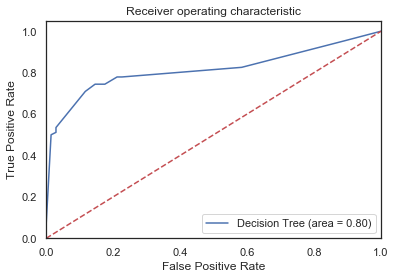

In [198]:
print("Decision tree has {} nodes with maximum depth {} \n".format(dtc.tree_.node_count, dtc.tree_.max_depth))
evaluate_model(pred, probs,train_pred, train_probs, y_train, y_test)

#### Feature Importance 
Computed by summing the reduction in GINI impurity over all the nodes of the tree in which the feature was used

In [199]:
fi = pd.DataFrame({'feature': features,
                   'importance': dtc.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)



,feature,importance
14,title_Mr,0.507013
1,single_fare,0.143434
18,family_size_grouped_large,0.120368
0,Pclass,0.063248
29,age_sex_M-26-40,0.040683
30,age_sex_M-41-55,0.037453
3,Embarked_S,0.017494
6,Cabin_D,0.016799
23,age_sex_F-41-55,0.016643
32,age_sex_M-55+,0.011627


#### Visualise the tree

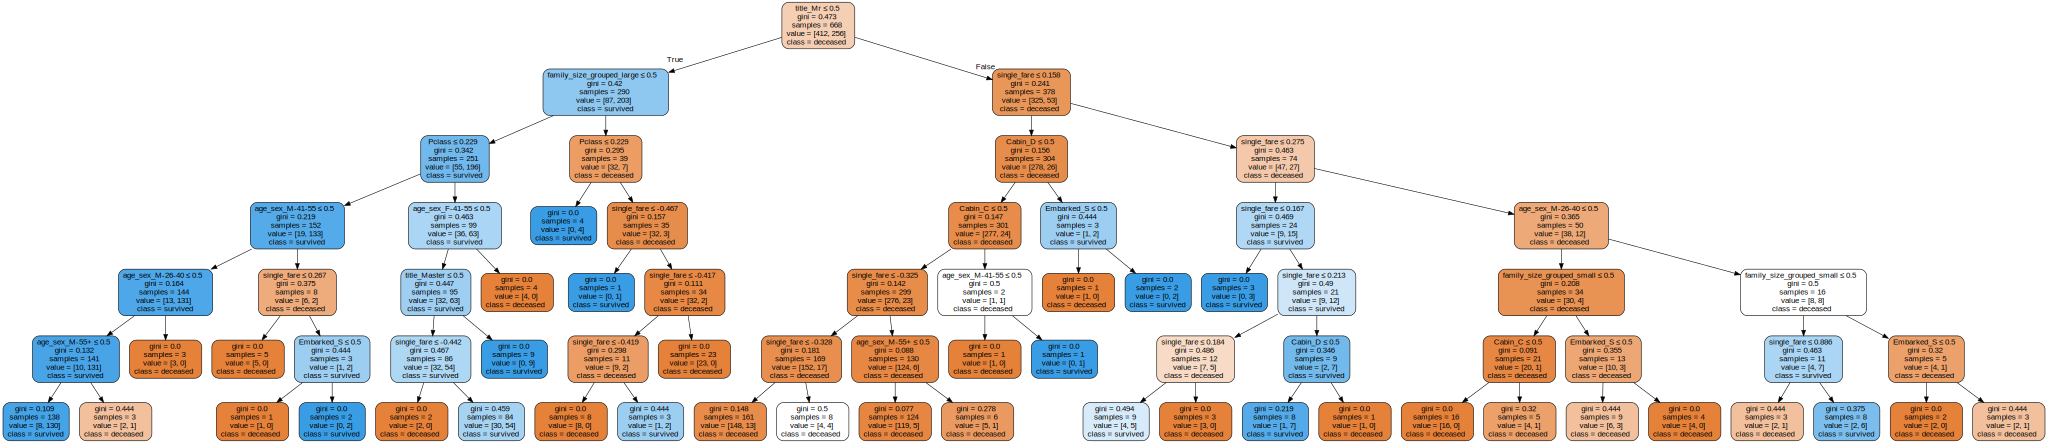

In [201]:
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(dtc, out_file=None, 
    feature_names=features,  
    class_names=['deceased', 'survived'],  
    filled=True, rounded=True,  
    special_characters=True, rotate=False)
graph = graphviz.Source(dot_data)
graph

<a id='kaggle'></a>

### 11. Kaggle
Code for kaggle submission  - apply model to kaggle test set
Kaggle Score 0.74162

In [207]:
#Feature engineering  and standardisation has already been applied
# test.head()
# # Have removed cabin T as does not exist in test set
features = ['Pclass',  'single_fare',  'Embarked_Q',
       'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G',  'Cabin_U', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Other', 'title_Rev',
       'family_size_grouped_large', 'family_size_grouped_small',
       'age_sex_F-11-17', 'age_sex_F-18-25', 'age_sex_F-26-40',
       'age_sex_F-41-55', 'age_sex_F-5-10', 'age_sex_F-55+', 'age_sex_M-0-4',
       'age_sex_M-11-17', 'age_sex_M-18-25', 'age_sex_M-26-40',
       'age_sex_M-41-55', 'age_sex_M-5-10', 'age_sex_M-55+'
    ]

best_depth = 5
dtc = DecisionTreeClassifier(max_depth = best_depth)
dtc.fit(train[features], train['Survived'])
predictions = dtc.predict(test[features])

# upload predictions to csv
ids = test['PassengerId']
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic_submission.csv', index=False)

In [205]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


#### Kaggle attempt take 2. Use Random Forest model below to see if there is an imptovement in kaggle score
0.76076

In [217]:
#Feature engineering  and standardisation has already been applied
# test.head()
# # Have removed cabin T as does not exist in test set
features = ['Pclass',  'single_fare',  'Embarked_Q',
       'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G',  'Cabin_U', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Other', 'title_Rev',
       'family_size_grouped_large', 'family_size_grouped_small',
       'age_sex_F-11-17', 'age_sex_F-18-25', 'age_sex_F-26-40',
       'age_sex_F-41-55', 'age_sex_F-5-10', 'age_sex_F-55+', 'age_sex_M-0-4',
       'age_sex_M-11-17', 'age_sex_M-18-25', 'age_sex_M-26-40',
       'age_sex_M-41-55', 'age_sex_M-5-10', 'age_sex_M-55+'
    ]



rf = RandomForestClassifier(n_estimators = 152,min_samples_split=10, max_leaf_nodes =  41,
                             max_features =  0.5, max_depth= 16, bootstrap = True, random_state = RSEED)


rf.fit(train[features], train['Survived'])
predictions = rf.predict(test[features])

# upload predictions to csv
ids = test['PassengerId']
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic_submission_rf.csv', index=False)

<a id='fin'></a>

# END
Code after this is just experimenting - not used

****************************************************************************************************************************

### Random Forest - base line
Accuracy on the train set: 96%  
Accuracy on the test set: 77.1%  
f1 on the test set: 67.9%


In [203]:
# Create the model with 100 trees
rfc = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
rfc.fit(X_train[features], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=101, verbose=1,
                       warm_start=False)

#### Check average nodes and depth per tree

In [204]:
n_nodes = []
max_depths = []

for ind_tree in rfc.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 291
Average maximum depth 18


#### Check Accuracy

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy on the train set: 0.960
Accuracy on the test set: 0.771

f1 on the train set: 0.947
f1 on the test set: 0.679

ROC AUC SCORE on the train set: 0.991
ROC AUC SCORE on the test set: 0.816

Baseline ROC AUC: 0.500

              precision    recall  f1-score   support

           0      0.787     0.861     0.822       137
           1      0.740     0.628     0.679        86

    accuracy                          0.771       223
   macro avg      0.763     0.745     0.751       223
weighted avg      0.769     0.771     0.767       223

[[118  19]
 [ 32  54]]


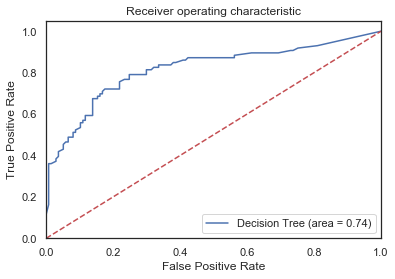

In [205]:
train_rf_predictions = rfc.predict(X_train[features])
rf_predictions = rfc.predict(X_test[features])

train_rf_probs = rfc.predict_proba(X_train[features])[:, 1]
rf_probs = rfc.predict_proba(X_test[features])[:, 1]

evaluate_model(rf_predictions, rf_probs,train_rf_predictions, train_rf_probs, y_train, y_test)

#### Check Feature Importance

In [206]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': rfc.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
1,single_fare,0.289795
14,title_Mr,0.140390
13,title_Miss,0.070525
0,Pclass,0.065803
19,family_size_grouped_small,0.051559
15,title_Mrs,0.047543
22,age_sex_F-26-40,0.042744
29,age_sex_M-26-40,0.032720
11,Cabin_U,0.028604
18,family_size_grouped_large,0.025627


### Grid Search CV Random Forest

Accuracy on the train set: 90.1%  
Accuracy on the test set: 80.3%  
f1 on the test set: 72.2%

In [212]:
from sklearn.ensemble import RandomForestClassifier

# I think this is quicker than grid search cv
from sklearn.model_selection import RandomizedSearchCV  


# Hyperparameter Grid
param_grid = {
    'n_estimators': np.linspace(5, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}



# #Pass the dicitionary and other parameters to GridSearchCV to create a GridSearchCV object
rfc = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(rfc, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 5, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(X_train[features], y_train)

# display the results
rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished


{'n_estimators': 152,
 'min_samples_split': 10,
 'max_leaf_nodes': 41,
 'max_features': 0.5,
 'max_depth': 16,
 'bootstrap': True}

#### Refit on data set using best params

In [213]:
# pd.DataFrame(rs.cv_results_)

In [214]:
# Refit on all of the train data and validate agianst the test 
best_model = rs.best_estimator_


train_rf_predictions = best_model.predict(X_train[features])
train_rf_probs = best_model.predict_proba(X_train[features])[:, 1]
rf_predictions = best_model.predict(X_test[features])
rf_probs = best_model.predict_proba(X_test[features])[:, 1]

In [215]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 81
Average maximum depth 11


Accuracy on the train set: 0.901
Accuracy on the test set: 0.803

f1 on the train set: 0.865
f1 on the test set: 0.722

ROC AUC SCORE on the train set: 0.959
ROC AUC SCORE on the test set: 0.830

Baseline ROC AUC: 0.500

              precision    recall  f1-score   support

           0      0.808     0.891     0.847       137
           1      0.792     0.663     0.722        86

    accuracy                          0.803       223
   macro avg      0.800     0.777     0.784       223
weighted avg      0.802     0.803     0.799       223

[[122  15]
 [ 29  57]]


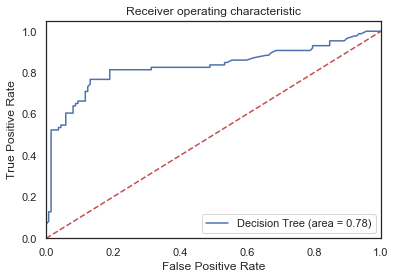

In [216]:
evaluate_model(rf_predictions, rf_probs,train_rf_predictions, train_rf_probs, y_train, y_test)

### Feature Selection?????

In [104]:
# data_final_vars=X_train.columns.values.tolist()
# # y=['y']
# X=[i for i in data_final_vars ]
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# rfe = RFE(logreg, 13)
# rfe = rfe.fit(X_train, y_train.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)
# print(np.where(rfe.support_ == True)[0])
# X_train.columns[np.where(rfe.support_ == True)[0]]

### Grid Search CV - Best Model

In [116]:


# cols1 = ['Pclass', 'family_size', 'single_fare', 'Sex_male', 'Embarked_Q',
#        'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
#        'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'title_Master',
#        'title_Miss', 'title_Mr', 'title_Mrs', 'title_Other', 'title_Rev',
#        'family_size_grouped_large', 'family_size_grouped_small', 'Age']

# cols2 = ['Pclass', 'family_size', 'single_fare',  'Embarked_Q',
#        'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
#        'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'title_Master',
#        'title_Miss', 'title_Mr', 'title_Mrs', 'title_Other', 'title_Rev',
#        'family_size_grouped_large', 'family_size_grouped_small', 
#        'age_sex_F-11-17', 'age_sex_F-18-25', 'age_sex_F-26-40',
#        'age_sex_F-41-55', 'age_sex_F-5-10', 'age_sex_F-55+', 'age_sex_M-0-4',
#        'age_sex_M-11-17', 'age_sex_M-18-25', 'age_sex_M-26-40',
#        'age_sex_M-41-55', 'age_sex_M-5-10', 'age_sex_M-55+']

# cols3 = ['single_fare','Age', 'Pclass', 'title_Mr']
# from sklearn.neighbors import  KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
# pipe = Pipeline([('classifier', LogisticRegression())])

# # Create param grid.

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(0, 4, 10),
#     'classifier__solver' : ['liblinear']},
    
#     {'classifier' : [DecisionTreeClassifier()],
#     'classifier__max_depth' : list(range(1,20))},
    
#     {'classifier' : [LogisticRegression()],
#     'classifier__C' : np.logspace(0, 4, 10),
#     'classifier__solver' : ['lbfgs']},
    
#     {'classifier' : [KNeighborsClassifier()],
#      'classifier__n_neighbors' : [1,5,11,15,21]}

# ]



# # First do with cols list cols1 then with cols list cols2
# # create a gridsearch of the pipeline, the fit the best model
# gridsearch = GridSearchCV(pipe, param_grid, cv=5, verbose=0,n_jobs=-1) # Fit grid search
# best_model = gridsearch.fit(X_train[cols1], y_train)

# # cols 1
# print(best_model.best_estimator_)
# print("The mean accuracy of the model is:",best_model.score(X_train[cols1], y_train))
# print("The mean accuracy of the model(test) is:",best_model.score(X_test[cols1], y_test))

# #cols 2
# best_model2 = gridsearch.fit(X_train[cols2], y_train)
# print(best_model2.best_estimator_)
# print("The mean accuracy of the model is:",best_model2.score(X_train[cols2], y_train))
# print("The mean accuracy of the model(test) is:",best_model2.score(X_test[cols2], y_test))

# #cols 3 This is just a check with v few columns
# #cols 2
# best_model3 = gridsearch.fit(X_train[cols3], y_train)
# print(best_model3.best_estimator_)
# print("The mean accuracy of the model is:",best_model3.score(X_train[cols3], y_train))
# print("The mean accuracy of the model(test) is:",best_model2.score(X_test[cols3], y_test))

## Feature Selection???

In [118]:
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(X_train,y_train)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(20).plot(kind='barh')
# plt.show()

In [ ]:
# def plot_train_test_accuracy(depth, train_accuracy, test_accuracy):
#     plt.figure(figsize=(8, 6))
    
#     plt.plot(depth, train_accuracy, linewidth=2.0, color='r', label="Train Accuracy")
#     plt.plot(depth, test_accuracy, linewidth=2.0, color='b', label="Test Accuracy")
    
#     plt.xlabel("Max Depth")
#     plt.ylabel("Accuracy")
#     plt.legend(loc='upper right')
#     plt.show()

# # Create two empty lists for train and test accuracy then iterate over a list of depths
# train_accuracy = []
# test_accuracy = []

# depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]

# for d in depths:
#     dtc = DecisionTreeClassifier(max_depth=d)
#     dtc.fit(X_train, y_train)
#     train_accuracy.append(dtc.score(X_train,y_train))
#     test_accuracy.append(dtc.score(X_test,y_test))
    
# plot_train_test_accuracy(depths, train_accuracy, test_accuracy)